## UnSu Unet Object Localization

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.initializers import he_uniform
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K


import numpy as np
import matplotlib.pyplot as plt

2024-10-24 17:09:18.952215: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-24 17:09:18.956188: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-24 17:09:19.054629: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-24 17:09:19.055880: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-24 17:09:20.397215: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
# Clear GPU memory
# K.clear_session()
# tf.config.experimental.reset_memory_stats('GPU:0')

In [4]:
# Import custom functions to extract our Image arrays and Pixel Mask arrays from our created fits files dataset
from dataGathering import extractImageArray, extractPixelMaskArray, extract_star_catalog
from dataGathering import getStarData, getImagePlot, getPixelMaskPlot
from dataGathering import displayRawImage, displayRawPixelMask, displayImagePlot, displayPixelMaskPlot, displayPixelMaskOverlayPlot

# Import astropy to read fits files, and os to interact with the file system
from astropy.io import fits
import os

In [5]:
# getStarData('II/246', 150, 'data')

In [6]:
# Create images and masks arrays lists
images = []
masks = []

# Create df to store the star data inside each fits file
star_data = []

# Create a list of all the fits files in the dataset folder
fits_files = os.listdir('data/')

# For all the fits files in the dataset folder specified in file_path, extract the image and mask arrays to the respective lists
file_path = 'data/'
for file in os.listdir(file_path):
    if file.endswith('.fits'):
        images.append(extractImageArray(file_path + file))
        masks.append(extractPixelMaskArray(file_path + file))
        star_data.append(extract_star_catalog(file_path + file))

        print(file + ' added to dataset')

data7.fits added to dataset
data4.fits added to dataset
data8.fits added to dataset
data9.fits added to dataset
data5.fits added to dataset
data0.fits added to dataset
data2.fits added to dataset
data6.fits added to dataset
data1.fits added to dataset
data3.fits added to dataset


In [7]:
fits_files[0]

'data7.fits'

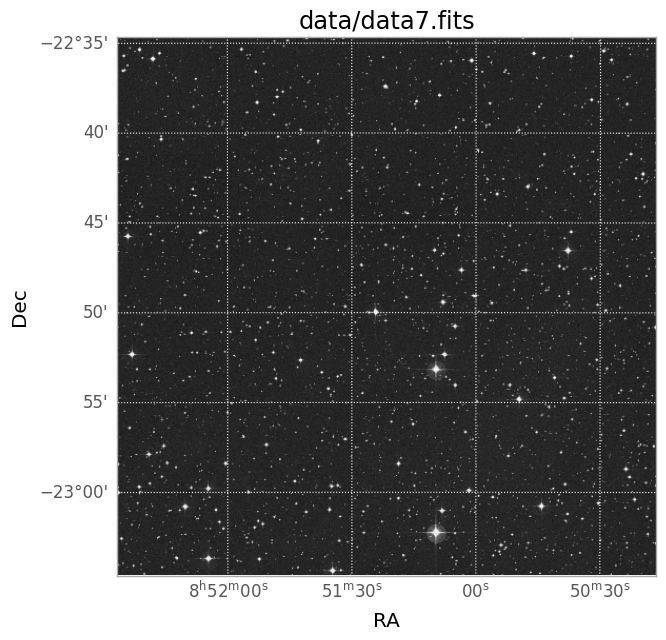

In [8]:
displayImagePlot(file_path + fits_files[0])

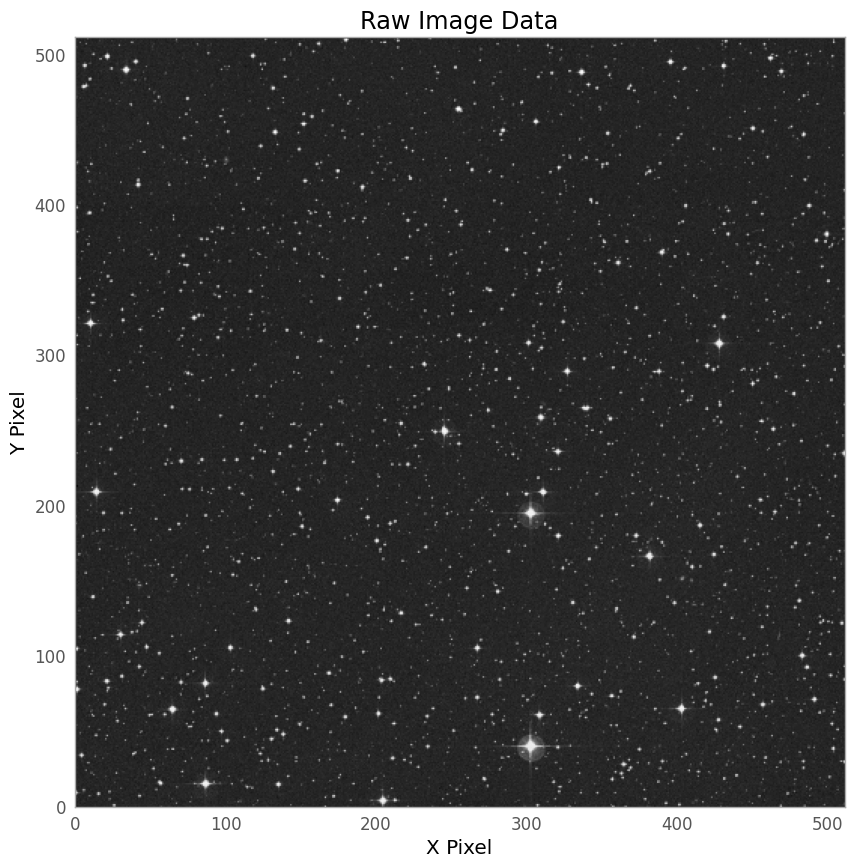

In [9]:
# Display the first image in the dataset using the array
displayRawImage(file_path + fits_files[0])

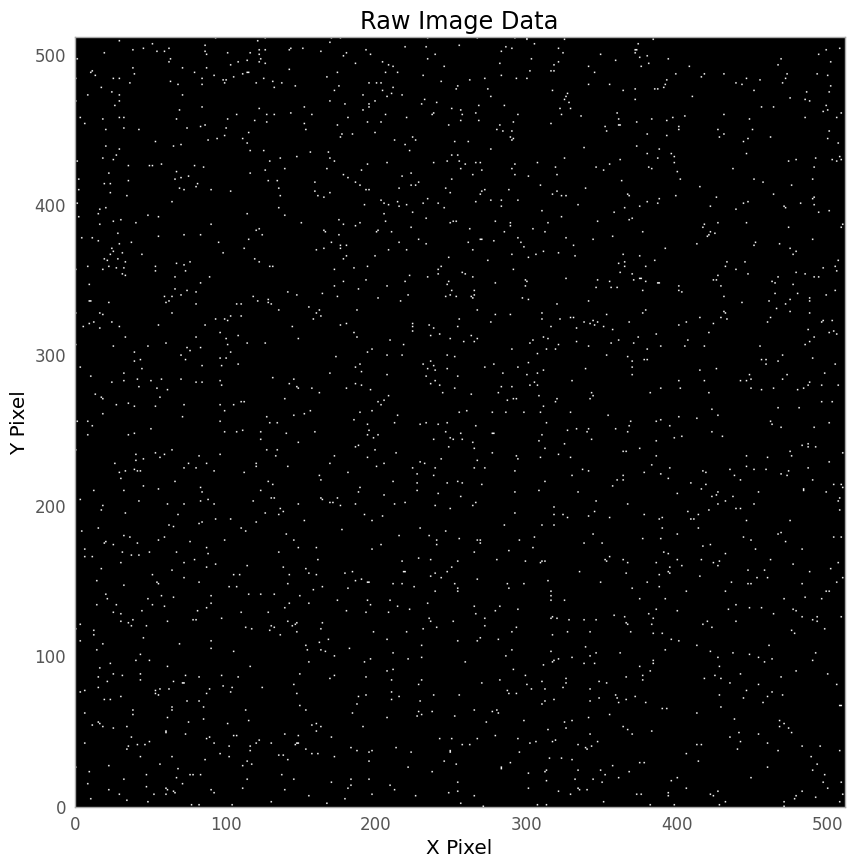

In [10]:
displayRawPixelMask(file_path + fits_files[0])

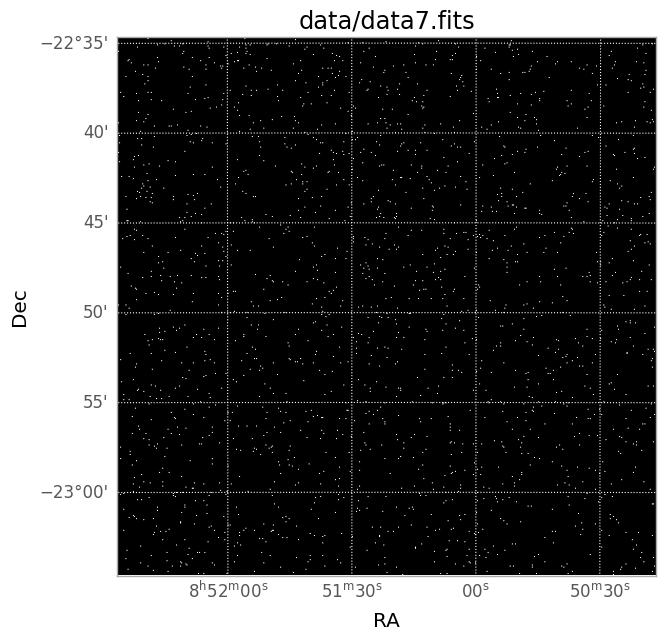

In [11]:
displayPixelMaskPlot(file_path + fits_files[0])

Number of stars in catalog query:  3179
Number of cataloged stars in image:  2074
Drawing


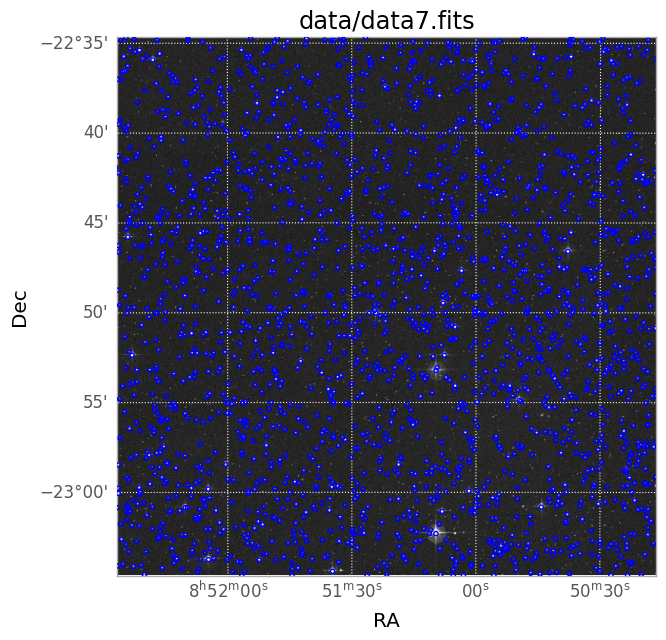

In [14]:
displayPixelMaskOverlayPlot(file_path + fits_files[0])

In [15]:
# Encoder path
    #32 kernels
    #3x3 kernel size
    #padding = same considers edges in the input
# Example function to create a U-Net model
def unet_model(input_shape, filters, kernel_size, activation, padding, initializer):
    inputs = layers.Input(input_shape)

    # Encoder path
    c1 = layers.Conv2D(filters[0], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(inputs)
    c1 = layers.Conv2D(filters[0], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(filters[1], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(p1)
    c2 = layers.Conv2D(filters[1], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(filters[2], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(p2)
    c3 = layers.Conv2D(filters[2], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(filters[3], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(p3)
    c4 = layers.Conv2D(filters[3], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(filters[4], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(p4)
    c5 = layers.Conv2D(filters[4], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c5)

    # Decoder path
    u6 = layers.Conv2DTranspose(filters[3], (2, 2), strides=(2, 2), padding=padding)(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(filters[3], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(u6)
    c6 = layers.Conv2D(filters[3], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c6)

    u7 = layers.Conv2DTranspose(filters[2], (2, 2), strides=(2, 2), padding=padding)(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(filters[2], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(u7)
    c7 = layers.Conv2D(filters[2], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c7)

    u8 = layers.Conv2DTranspose(filters[1], (2, 2), strides=(2, 2), padding=padding)(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(filters[1], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(u8)
    c8 = layers.Conv2D(filters[1], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c8)

    u9 = layers.Conv2DTranspose(filters[0], (2, 2), strides=(2, 2), padding=padding)(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(filters[0], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(u9)
    c9 = layers.Conv2D(filters[0], kernel_size, activation=activation, padding=padding, kernel_initializer=initializer)(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

In [16]:
# Prepare the model for training
#############################################

# Define the base exponent
base_exponent = 5
#############################################
# base_exponent = 5, so filters result in [32, 64, 128, 256, 512], this was the original value
# base_exponent = 6, so filters result in [64, 128, 256, 512, 1024]
# base_exponent = 7, so filters result in [128, 256, 512, 1024, 2048]
# base_exponent = 8, so filters result in [256, 512, 1024, 2048, 4096]
# base_exponent = 9, so filters result in [512, 1024, 2048, 4096, 8192]
# base_exponent = 10, so filters result in [1024, 2048, 4096, 8192, 16384]

# Generate the filters based on powers of 2
filters = [2 ** (base_exponent + i) for i in range(5)]
#############################################
# This list comprehension generates the filter sizes by raising 2 to the powers starting from the base exponent and increasing by 1 for each subsequent filter.
#############################################

# Enable mixed precision training
# Mixed precision training can help reduce memory usage and speed up training by using both 16-bit and 32-bit floating point types.
# tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Define hyperparameters
hyperparameters = {
    'input_shape': (512, 512, 3),
    'filters': filters,
    'kernel_size': (3, 3),
    'activation': 'relu',
    'padding': 'same',
    'initializer': he_uniform(),
    'optimizer': 'adam',
    'loss': 'binary_crossentropy',
    'metrics': ['accuracy'],
    'epochs': 1000,
    'batch_size': 4,
    'validation_split': 0.2,
    'early_stopping_patience': 10
}

# Create and compile the model using hyperparameters
model = unet_model(
    input_shape=hyperparameters['input_shape'],
    filters=hyperparameters['filters'],
    kernel_size=hyperparameters['kernel_size'],
    activation=hyperparameters['activation'],
    padding=hyperparameters['padding'],
    initializer=hyperparameters['initializer']
)
model.compile(
    optimizer=hyperparameters['optimizer'],
    loss=hyperparameters['loss'],
    metrics=hyperparameters['metrics']
)

/home/chris/GitHub/AstrID/.venv/lib/python3.10/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer HeUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [46]:
# Prepare the data for training
#############################################

# Define the test size
image_parameters = {
    'test_size': 0.2,
    'random_state': 0
}


# # Convert lists to numpy arrays
# # This ensures that the data is in the correct format for train_test_split and model.fit.
# train_images = np.array(images)
# train_masks = np.array(masks)

train_images = images
train_masks = masks

train_images[0].shape


(512, 512)

In [47]:

# Split the dataset into training and validation sets
train_images, val_images, train_masks, val_masks = train_test_split(train_images, train_masks, test_size=image_parameters['test_size'], random_state=image_parameters['random_state'])

# Duplicate channels for the grayscale images since the model expects 3 channels
for i in range(len(train_images)):
    train_images[i] = np.repeat(train_images[i], 3, axis=-1)
for i in range(len(val_images)):
    val_images[i] = np.repeat(val_images[i], 3, axis=-1)

train_images[0].shape

(512, 1536)

In [35]:

# Use ImageDataGenerator to load data in batches
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(train_images, train_masks, batch_size=hyperparameters['batch_size'])
val_generator = val_datagen.flow(val_images, val_masks, batch_size=hyperparameters['batch_size'])

# Show distribution of training and validation sets
print('Training images: ', train_images.shape)
print('Training masks: ', train_masks.shape)
print('Validation images: ', val_images.shape)
print('Validation masks: ', val_masks.shape)

ValueError: `x` (images tensor) and `y` (labels) should have the same length. Found: x.shape = (512, 1536), y.shape = (8, 512, 512)

In [16]:
# Train the model
#############################################

# Implement Early stopping to cut useless epochs
early_stopping = EarlyStopping(
    monitor='val_loss',  # or another metric like 'val_accuracy'
    patience=hyperparameters['early_stopping_patience'],         # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restores the model to the best state after stopping
)


# Train the model
history = model.fit(train_images, train_masks, 
                    validation_data=(val_images, val_masks), 
                    epochs=hyperparameters['epochs'], 
                    batch_size=hyperparameters['batch_size'],
                    callbacks=[early_stopping])

2024-10-23 19:17:29.408937: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 377487360 exceeds 10% of free system memory.
2024-10-23 19:17:29.737552: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 377487360 exceeds 10% of free system memory.


Epoch 1/1000


/home/chris/GitHub/AstrID/.venv/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(
I0000 00:00:1729736252.681540    9377 service.cc:146] XLA service 0x7f32f4008ed0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729736252.681600    9377 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-10-23 19:17:32.817819: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-23 19:17:33.219527: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-10-23 19:17:41.018942: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.11GiB w

30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 217ms/step - accuracy: 0.9658 - loss: 79.4336 - val_accuracy: 0.9958 - val_loss: 11.2040
Epoch 2/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.9902 - loss: 16.5405 - val_accuracy: 0.9959 - val_loss: 8.7417
Epoch 3/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.9900 - loss: 10.3875 - val_accuracy: 0.9959 - val_loss: 6.0479
Epoch 4/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.9928 - loss: 4.9974 - val_accuracy: 0.9858 - val_loss: 1.7463
Epoch 5/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.9897 - loss: 2.2757 - val_accuracy: 0.9776 - val_loss: 1.6584
Epoch 6/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.9858 - loss: 3.0595 - val_accuracy: 0.9708 - val_loss: 1.7956
Epoch 7/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.9880 - loss: 1.8868 - val_accuracy: 0.9951 - val_loss: 1.0899
Epoch 8/1000
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.9879 - loss: 2.6455 - val_accuracy: 0

In [17]:
# Show training loss and validation loss
print('Training loss: ', history.history['loss'][-1])
print('Validation loss: ', history.history['val_loss'][-1])

# Show training accuracy and validation accuracy
print('Training accuracy: ', history.history['accuracy'][-1])
print('Validation accuracy: ', history.history['val_accuracy'][-1])

Training loss:  0.032066334038972855
Validation loss:  0.026794753968715668
Training accuracy:  0.9949293732643127
Validation accuracy:  0.995926558971405


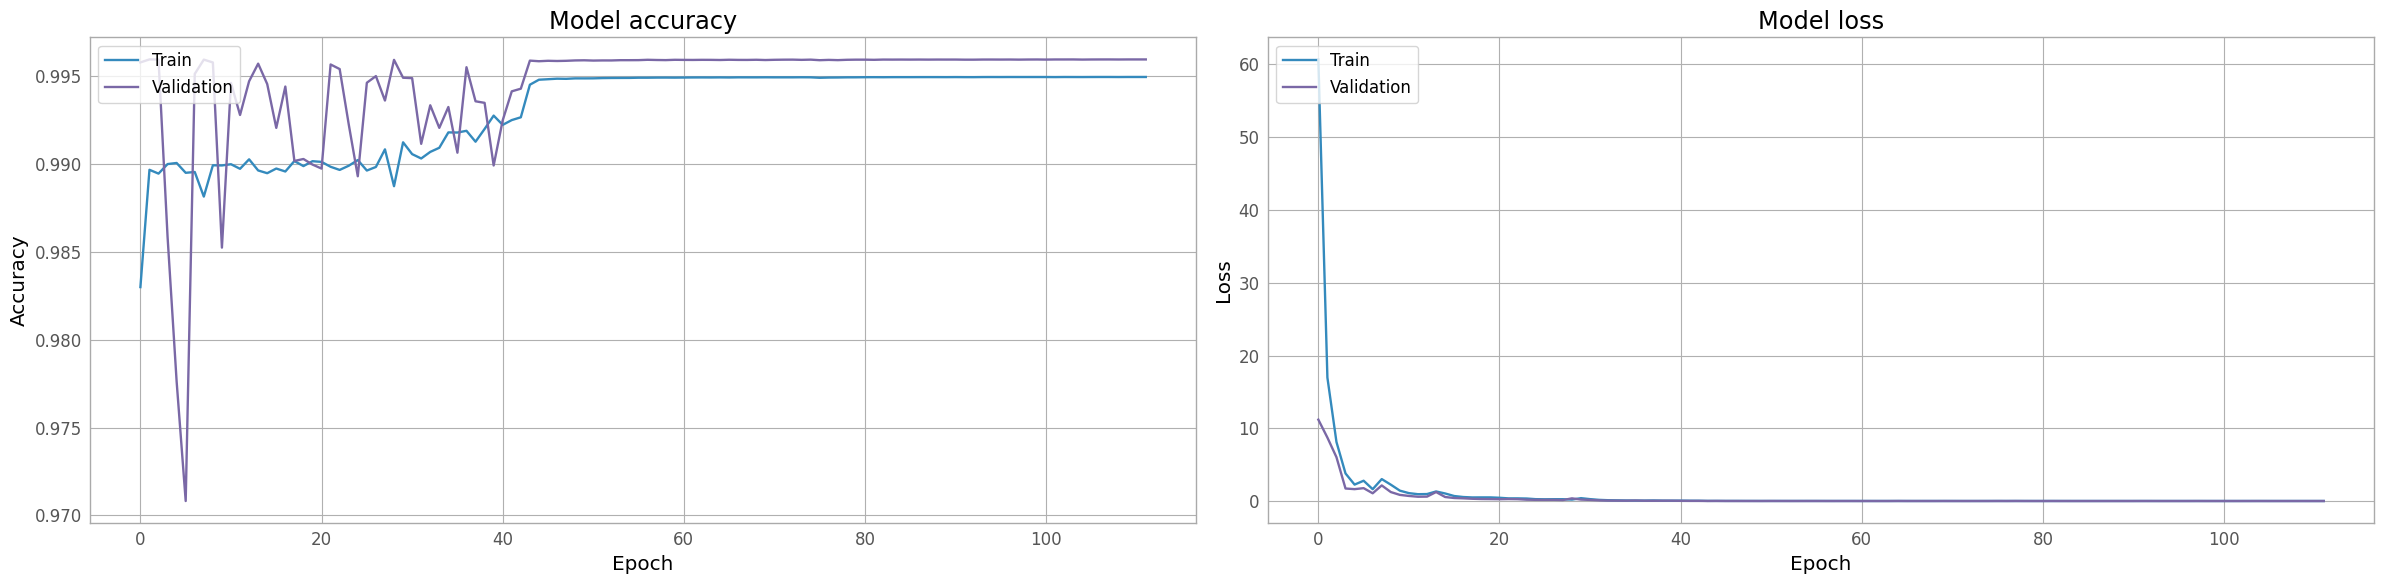

In [18]:
# Plot training & validation accuracy values
plt.figure(figsize=(24, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [19]:
# Save the model
model.save('150unet_model_3.keras')

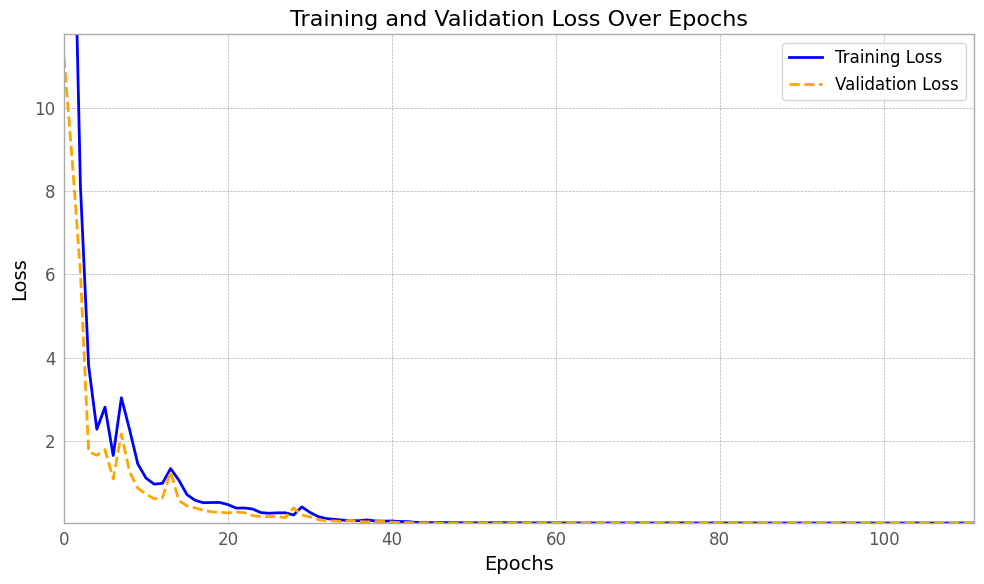

: 

In [20]:



# Set a larger figure size
plt.figure(figsize=(10, 6))

# Plot the training and validation loss
plt.plot(history.history['loss'], color='blue', linestyle='-', linewidth=2, label='Training Loss')
plt.plot(history.history['val_loss'], color='orange', linestyle='--', linewidth=2, label='Validation Loss')

# Add title and labels
plt.title('Training and Validation Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)

# Add a grid for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add legend to differentiate between training and validation loss
plt.legend(loc='best', fontsize=12)

# Set limits for better visualization
plt.xlim(0, len(history.history['loss']) - 1)  # From epoch 0 to the last epoch
plt.ylim(min(history.history['loss']) * 0.95, max(history.history['val_loss']) * 1.05)

# Show the plot
plt.tight_layout()
plt.show()
